In [ ]:
#to do: run in the cloud

In [532]:
import json
import numpy as np
import os
import pandas as pd

<H2>Load Data</H2>

In [540]:
#Load human generated data
def json_to_df(path) :
    df = pd.DataFrame()
    with open(path, 'r') as f:
        for x in f:
            item = json.loads(x)
            df = df.append(item, ignore_index = True)
    return df
     
path = '/Users/kipnisal/Data/AuthorshipAI/GPT2/webtext.test.jsonl'
data_human = json_to_df(path)

data_human = data_human.rename(columns = {'article' : 'text', 'title' : 'doc_id', 'label' : 'author'})
data_human = data_human.rename(columns = {'id' : 'doc_id', 'length' : 'no_words'})
data_human.loc[:,'author'] = 'human'

<H3>GPT</H3>

In [553]:
#Load GPT generated data
def json_to_df(path) :
    df = pd.DataFrame()
    with open(path, 'r') as f:
        for x in f:
            item = json.loads(x)
            df = df.append(item, ignore_index = True)
    return df
     
path = '/Users/kipnisal/Data/AuthorshipAI/GPT2/small-117M-k40.test.jsonl'
data_GPT = json_to_df(path)

data_GPT = data_GPT.rename(columns = {'article' : 'text', 'title' : 'doc_id', 'label' : 'author'})
data_GPT = data_GPT.rename( columns = {'id' : 'doc_id', 'length' : 'no_words'})
data_GPT.loc[:,'author'] = 'GPT2'

In [595]:
#merge human and GPT
data_all = pd.concat([data_GPT.head(2000), data_human.head(2000)], sort = False).reset_index()

train_test_ratio = 0.8
data_all.loc[:,'split'] = 'train'
k = len(data_all)
ix_test = np.random.permutation(data_all.index)[:int(train_test_ratio * k)]
data_all.loc[ix_test,'split'] = 'test'

data_all = data_all.reindex(np.random.permutation(data_all.index))

<H3>Grover</H3>

In [294]:
# Load Grover
def json_to_df(path) :
    df = pd.DataFrame()
    with open(path, 'r') as f:
        for x in f:
            item = json.loads(x)
            df = df.append(item, ignore_index = True)
    return df
     
path = 'generator=mega_dataset=p0.94.jsonl'
data_Grover = json_to_df(path)

In [ ]:
data_Grover = pd.read_csv('~/Data/Gover_challenge_stemed.csv')

In [ ]:
lo_domains = ['theguardian.cm', 'theatlantic.com', 'seekingalpha.com', 'chicagotribune.com']
lo_authors = ['Nathan Grayson', 'The Associated Press', 'Ben Hernandez', 'Chris Evangelista',
              'Carena Liptak', 'Matt Webb Mitovich', 'Kyle Wiggers', 'Ethan Anderton']
lo_authors_tvline = ['Matt Webb Mitovich', 'Kimberly Roots', 'Rebecca Iannucci', 'Andy Swift']
#data = data_all[data_all.domain == 'seekingalpha.com']
#data = data_all[data_all.authors.isin(lo_authors)]

#data = data_all.groupby('split').head(250)
data = data_Grover.copy()
data[data.split == 'val']['split'] = 'train'
data.loc[:,'type'] = data.loc[:,'author'] 
data.loc[:,'author'] = data.loc[:,'authors'] 
data.loc[:,'doc_id'] = data.loc[:,'doc_id'] + '(' + data.loc[:,'type'] + ')'

data = data[data.author.isin(['Kimberly Roots', 'Matt Webb Mitovich'])]
#data = data[data.domain.isin(['oregonlive.com', 'arkansasonline.com'])]

#data.loc[:,'author'] = data['type']

#data.loc[:,'split'] = data.type.apply(lambda l : 'train' if l == 'human' else 'test')
data.loc[:,'split'] = data.type.apply(lambda l : 'test' if l == 'human' else 'train')

data.groupby(['author','type','split']).describe().iloc[:,0]

data = data.filter(['author','split','doc_id', 'text', 'type'])
data.loc[:,'no_words'] = data.text.astype(str).apply(lambda x : len(x.split()))

#train/test split
ds_train = data[data.split == 'train']
ds_test = data[data.split == 'test']

n = 2

if n > 1 : # merge n texts together
    ds_train = merge_consecutive(ds_train, n)
    ds_test = merge_consecutive(ds_test, n)
    
print("number of samples: train/test = {}/{} ".format(len(ds_train),len(ds_test)))
data_all = data

<H2>Pre-process</H2>

In [ ]:
# stem or pre-process
import sys
sys.path.append('/Users/kipnisal/Documents/Authorship/')
from text_processing import *

data_all = data_all.rename(columns = {'article' : 'text', 'title' : 'doc_id', 'label' : 'author'})
data_all.text = data_all.text.astype(str).apply(lambda x : preprocess_text(x, stem = True,
                                                            #clean_names = True,
                                                            #clean_html_tags = True,
                                                            #clean_digits = True
                                                           ))
data_all.to_csv('~/Data/machine_generated_stemed.csv')

<H3>Filter and re-arrange</H3>

In [575]:
def merge_consecutive(ds, n = 1) :
    # use this function to increase size of documents while maintaining
    # separation to authors
    # 
    # Output is shuffled
    ds_all = pd.DataFrame()
    for g in ds.groupby('author') :
        merged_text = g[1].groupby(np.arange(len(g[1]))//n).text.agg(sum)
        df = g[1].iloc[np.arange(0,len(g[1]),n)].reset_index()
        df.text = merged_text
        ds_all = ds_all.append(df)

    ds_all = ds_all.reset_index()
    ds_all.loc[:,'no_words'] = ds_all.text.astype(str).apply(lambda x : len(x.split()))
    
    ds_all = ds_all.reindex(np.random.permutation(ds_all.index))
    return ds_all

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


author              type     split
Kimberly Roots      human    test     14.0
                    machine  train     7.0
Matt Webb Mitovich  human    test     29.0
                    machine  train    15.0
Name: (Unnamed: 0, count), dtype: float64

In [591]:
data = data_all.filter(['author','split','doc_id', 'text', 'type'])
data.loc[:,'no_words'] = data.text.astype(str).apply(lambda x : len(x.split()))

#train/test split
ds_train = data[data.split == 'train']
ds_test = data[data.split == 'test']

n = 4

if n > 1 : # merge n texts together
    ds_train = merge_consecutive(ds_train, n)
    ds_test = merge_consecutive(ds_test, n)
    
print("number of samples: train/test = {}/{} ".format(len(ds_train),len(ds_test)))

number of samples: train/test = 501/2001 


<H1>Train Model</H1>

In [592]:
%load_ext autoreload
import os
import re
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('/Users/kipnisal/Documents/Authorship/')

from AuthAttLib import *
from visualize_HC_scores import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [596]:
#load preset vocabulary
STEM = False
from text_processing import *
VOCAB_SIZE = 5000
vocab5000 = pd.read_csv('~/Data/5000 most common english words.csv')
vocab = list(pd.unique(vocab5000[vocab5000.Rank <= VOCAB_SIZE].Word))
if STEM :
    vocab = stem_text(" ".join(vocab)).split()
    vocab = list(set(vocab)) # to remove dublicate terms

In [597]:
words_to_ignore = ['ms','mr' ,'dr', 'miss', 'york', 'courtesi', 'trump', 'million',
                  'michael','john','donald', 'email', 'meghan', 'bbc', 'nigeria', 'kim',
                  'buttigieg', 'cleveland', 'gov', 'saturday', 'sunday', 'sp', 'amazon',
                  'jone', 'la', 'barr','cathedr', 'duke', 'airlin', 'doe', 'jackson',
                  'africa','alberta','iran', 'nfl', 'andrew', 'davi', 'de', 'en', 'khan',
                  'dame','chicago', 'florida']

In [598]:
#train model
model = AuthorshipAttributionMulti(ds_train,
                               vocab = vocab,
                          #    vocab_size = 500,
                          #    ngram_range = (1,1),
                          #  words_to_ignore = words_to_ignore,
                              stbl = True)

df0 = model.internal_stats_corpus()
df0

	 Creating author-model for human using 4352 features
		found 249 documents and 294745 relevant tokens
	 Creating author-model for GPT2 using 4352 features


  0%|          | 0/2 [00:00<?, ?it/s]

		found 252 documents and 379697 relevant tokens


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


,HC,author,chisq,chisq_pval,cosine,feat,no_docs (author),no_docs (wrt_author),no_tokens (author),wrt_author
0,47.2502,human,23601.382871,0.0,0.00723,"[the, be, and, a, in, to, have, it, that, for,...",249.0,252.0,294745.0,GPT2


In [603]:
pd.DataFrame(df0.feat.values[0])

,0
0,the
1,be
2,and
3,a
4,in
5,to
6,have
7,it
8,that
9,for


In [586]:
# reduce features
model.reduce_features(df0.feat.values[0])
df0 = model.internal_stats_corpus()
df0

Changing vocabulary for GPT2. Found 74992 relevant tokens


100%|██████████| 2/2 [00:00<00:00, 14.10it/s]

Changing vocabulary for human. Found 50503 relevant tokens


,HC,author,chisq,chisq_pval,cosine,feat,no_docs (author),no_docs (wrt_author),no_tokens (author),wrt_author
0,192503.741377,human,4738.122575,0.0,0.011792,"[the, and, of, it, that, you, do, this, his, f...",99.0,102.0,50503.0,GPT2


In [600]:
ds_test_sm = ds_test.head(100)
df_test = model.stats_list(ds_test_sm)
df_test = df_test.merge(ds_test_sm.filter(['doc_id','type']), how = 'left', on = 'doc_id')

100%|██████████| 2/2 [05:50<00:00, 179.46s/it]


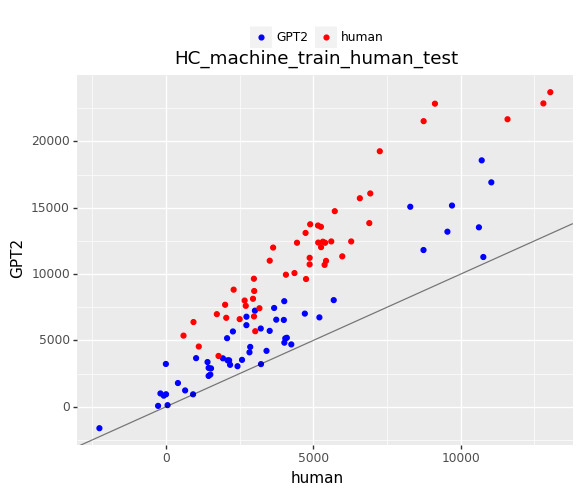

<ggplot: (-9223372036534047067)>


In [601]:
title = "HC_human_train_machine_test"
title = "HC_machine_train_human_test"
p = plot_author_pair(df_test, value = 'chisq', title = title)
#p.save(title + '.png')
print(p)

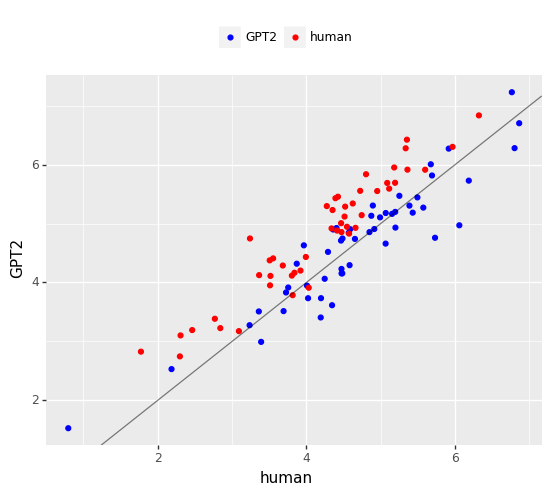

<ggplot: (320104673)>


In [602]:
p = plot_author_pair(df_test, value = 'HC')
#p.save(title + '.png')
print(p)

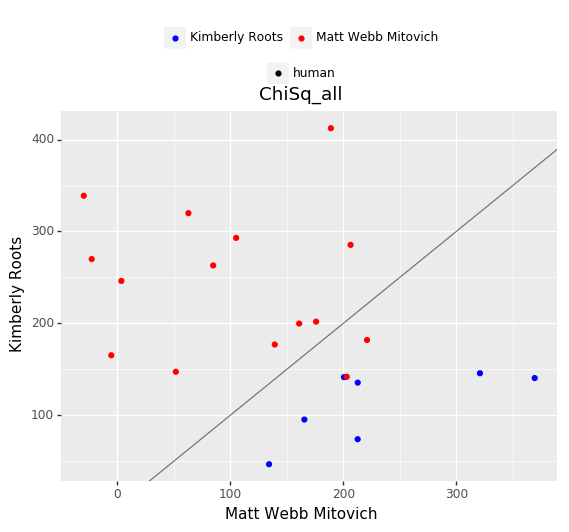

<ggplot: (316439514)>


In [524]:
title = "ChiSq_all"
p = plot_author_pair(df_test, value = 'chisq', title = title)
#p.save(title + '.png')
print(p)

In [366]:
def plot_author_pair(df, value = 'HC', wrt_author = [],
                     show_legend=True, title=""):
    
    df1 = df.filter(['doc_id', 'author', 'wrt_author', 'type', value])\
            .pivot_table(index = ['doc_id','author','type'],
                         columns = 'wrt_author',
                         values = [value])[value].reset_index()

    lo_authors = pd.unique(df1.author)
    no_authors = len(lo_authors)
    
    if no_authors < 2 :
        raise ValueError
    
    if wrt_author == [] :
        wrt_author = (lo_authors[0],lo_authors[1])

    if (no_authors == 2):
        color_map = {wrt_author[0]: "red", wrt_author[1]: "blue"}
    else:
        color_map = LIST_OF_COLORS

    df1.loc[:, 'x'] = df1.loc[:, wrt_author[0]].astype('float')
    df1.loc[:, 'y'] = df1.loc[:, wrt_author[1]].astype('float')
    p = (
        ggplot(aes(x='x', y='y', color='author', shape = 'type'), data=df1) +
        geom_point(show_legend=show_legend) + geom_abline(alpha=0.5) +
        # geom_text(aes(label = 'doc_id', check_overlap = True)) +
        xlab(wrt_author[0]) + ylab(wrt_author[1]) +
        scale_color_manual(values=color_map) +  #+ xlim(0,35) + ylim(0,35)
        ggtitle(title) #+ xlim(-5,10) + ylim(-5,10)
        + theme(legend_title=element_blank(), legend_position='top'))
    return p

In [10]:
#try on test set 
ds_test_sm = ds_test_db.head(10)

acc = 0
no_sm = 0
for r in tqdm(ds_test_sm.iterrows()) :
    res = model.predict(r[1].text, method='rank')
    no_sm += 1
    if r[1].author == res[0] :
        acc += 1
    print("accuracy = {}".format(acc / no_sm))

1it [00:00,  1.86it/s]

accuracy = 0.0


2it [00:01,  1.83it/s]

accuracy = 0.5


3it [00:01,  1.81it/s]

accuracy = 0.6666666666666666


4it [00:02,  1.85it/s]

accuracy = 0.75


5it [00:02,  1.84it/s]

accuracy = 0.8


6it [00:03,  1.91it/s]

accuracy = 0.6666666666666666


7it [00:03,  1.96it/s]

accuracy = 0.5714285714285714


8it [00:04,  1.89it/s]

accuracy = 0.625


9it [00:04,  1.90it/s]

accuracy = 0.5555555555555556


10it [00:05,  1.80it/s]

accuracy = 0.6


In [11]:
# evaluate on test set
ds_test_sm = ds_test_db.head(10)
df_test = pd.DataFrame()
for r in ds_test_sm.iterrows() :
    df1 = model.predict_stats(r[1].text)
    df1.loc[:,'author'] = r[1].author
    df1.loc[:,'doc_id'] = r[1].doc_id
    df_test = df_test.append(df1)


In [15]:
ds_test_sm = ds_test_db.head(50)
df_test = model.stats_list(ds_test_sm)

100%|██████████| 2/2 [00:25<00:00, 13.03s/it]


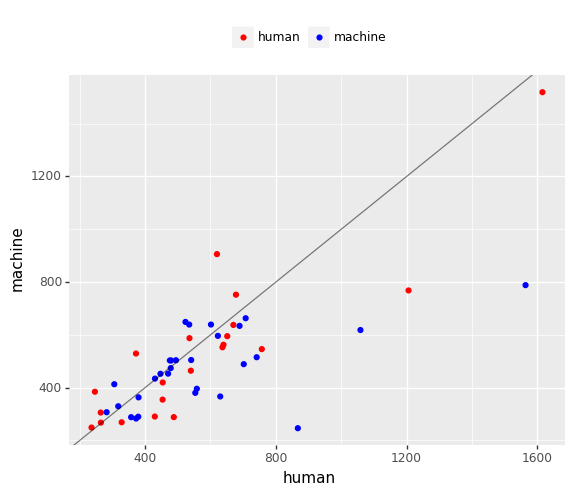

<ggplot: (307352289)>

In [16]:
def plot_author_pair(df, value = 'HC', wrt_author = [],
                     show_legend=True, title=""):
    
    df1 = df.filter(['doc_id', 'author', 'wrt_author', value])\
            .pivot_table(index = ['doc_id','author'],
                         columns = 'wrt_author',
                         values = [value])[value].reset_index()

    lo_authors = pd.unique(df1.author)
    no_authors = len(lo_authors)
    
    if no_authors < 2 :
        raise ValueError
    
    if wrt_author == [] :
        wrt_author = (lo_authors[0],lo_authors[1])

    if (no_authors == 2):
        color_map = {wrt_author[0]: "red", wrt_author[1]: "blue"}
    else:
        color_map = LIST_OF_COLORS

    df1.loc[:, 'x'] = df1.loc[:, wrt_author[0]].astype('float')
    df1.loc[:, 'y'] = df1.loc[:, wrt_author[1]].astype('float')
    p = (
        ggplot(aes(x='x', y='y', color='author'), data=df1) +
        geom_point(show_legend=show_legend) + geom_abline(alpha=0.5) +
        # geom_text(aes(label = 'doc_id', check_overlap = True)) +
        xlab(wrt_author[0]) + ylab(wrt_author[1]) +
        scale_color_manual(values=color_map) +  #+ xlim(0,35) + ylim(0,35)
        ggtitle(title) #+ xlim(0,5000) + ylim(0,5000)
        + theme(legend_title=element_blank(), legend_position='top'))
    return p

plot_author_pair(df_test, value = 'chisq')

100%|██████████| 2/2 [00:50<00:00, 25.48s/it]


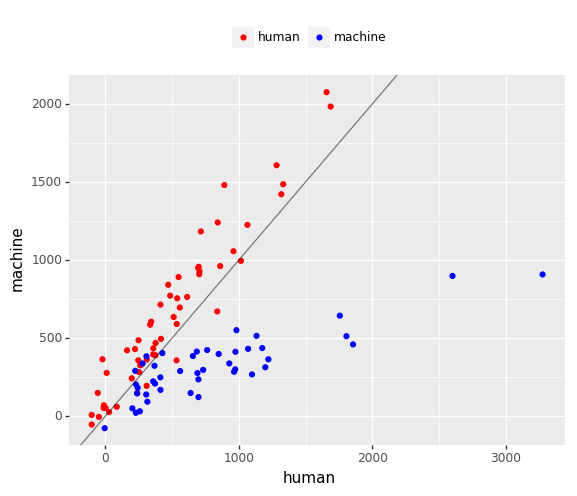

<ggplot: (-9223372036544183236)>

In [20]:
df1 = model.internal_stats()
plot_author_pair(df1, value = 'chisq')

100%|██████████| 2/2 [00:49<00:00, 24.46s/it]


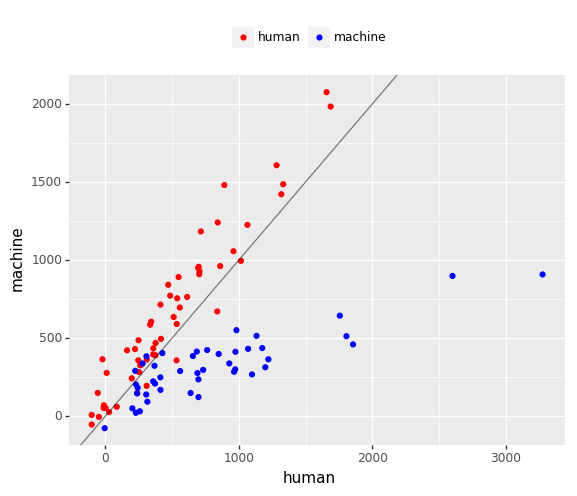

<ggplot: (308156522)>